# Preprocessing Atari Frames
Unlike simple environments like CartPole where little or no preprocessing is needed, the Atari environments require processing due to their high dimensionality. I have chosen to use the Tennis-v0 environment here and have tailored the preprocessing steps to that environment. The concepts here can be generalized however to a one-size-fits-all model.

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import scipy as sc
import scipy.misc

In [2]:
env = gym.make('Tennis-v0')
print("Observation shape: {}".format(env.observation_space.shape))
print("No. of actions: {}".format(env.action_space.n))

[2017-05-14 12:08:33,365] Making new env: Tennis-v0


Observation shape: (250, 160, 3)
No. of actions: 18


In [3]:
def show(img, gray=False):
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.show()

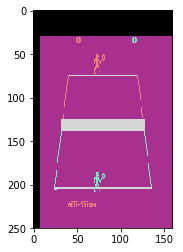

In [4]:
s = env.reset()
show(s)

As the image above illustrates, every state is a 250 x 160 RGB image (3-channel). If we used a single one as an input to a neural network, that would be $250 * 160 * 3 = 120000$ inputs (the problem would be compounded even more when frame stacking is introduced). With a little bit of work, we can potentially bring this down to a reasonable number.

The first thing that you may have noticed is that there are black bars to the top and left of the image. We could start by cropping those of. Before we do that however, also notice that in a play, the players never go beyond a certain bounding rectangle (just below the score and just above the Activision logo).

In [6]:
s = env.reset()
done = False
while not done:
    env.render()
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

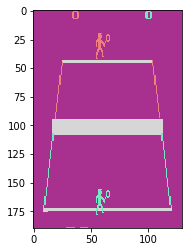

(190, 130, 3)


In [7]:
s = env.reset()
s = s[30:220, 15:145]
show(s)
print(s.shape)

By cropping, we have reduced the state to a 190 x 130 RGB image. Approximately 62% of the original. Another commonly employed technique is to convert the image to grayscale (single channel). Although, some information will be lost, it is often minimal and leads to the most savings in terms of dimensions. I convert the image to grayscale as follows:

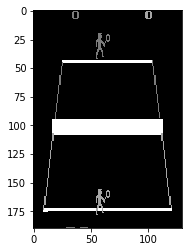

(190, 130)


In [8]:
s = np.mean(s, axis=2)
show(s, gray=True)
print(s.shape)

The result is a single channel image that is approximately 21% of the original. Notice that although we could have used a library like OpenCV to perform the conversion to grayscale, I simply use a mean operation here. Since this will be performed for every single state across all episodes, it will become expensive really quickly, so the simpler the better. Also notice that although both players look similar, one is slightly darker than the other (the one at the top who was originally red/orange and represents the agent) so the agent hopefully can still tell them apart (if at all that is important in learning).

The final reduction step will be to scale the state down by a factor of 2 for even more reductions to obtain a 95 x 65 grayscale image. The final reduced image will then be approximately 5% of the original (a lot of savings). Below, I display the first few frames in their unprocessed form. I then display the processed frames so you can compare and see the differences.

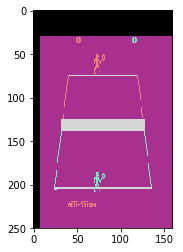

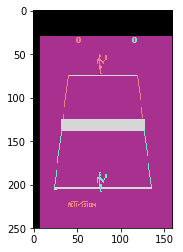

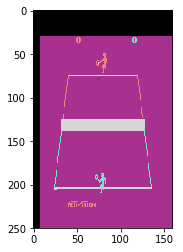

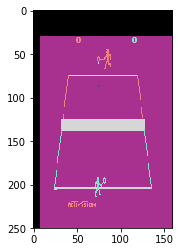

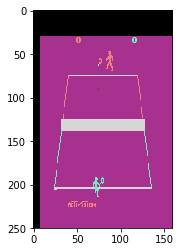

In [9]:
# Unprocessed version
s = env.reset()
done = False
for i in range(5):
    show(s)
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

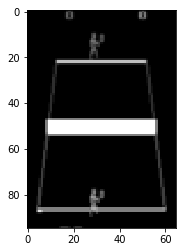

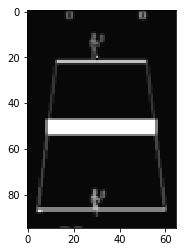

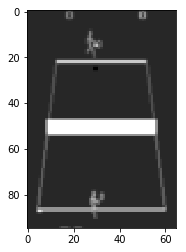

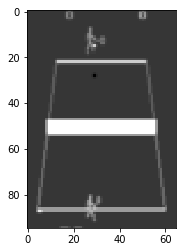

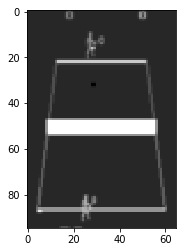

In [10]:
# Reduced version
s = env.reset()
done = False
for i in range(5):
    s = np.mean(s, axis=2)
    s = s[30:220, 15:145]
    s = sc.misc.imresize(s, (95,65))
    show(s, gray=True)
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

Before we wrap this up, there's 2 other techniques we need to discuss - frame stacking and repeating actions. 

### Repeating Actions
Holding down a button for what seems like a mere instant for a human actually occurs over several frames. We can extend that notion here, by repeating an action selected by the agent over several frames.

### Frame Stacking
If I gave you the last frame from the sequence above (raw or reduced) and asked you to guess the direction of the ball, chances are you would be wrong at least 50% of the time. Similarly, the agent may have a hard time figuring out the direction of the ball if given only a single frame. To solve this problem, we use a sequence of frames as the network input to allow the agent to learn to infer motion. You can visualize the process as follows:


In [11]:
# Reduced version
states = []
s = env.reset()
done = False
for i in range(5):
    s = np.mean(s, axis=2)
    s = s[30:220, 15:145]
    s = sc.misc.imresize(s, (95,65))
    s = s * (1. / 255)
    states.append(s)
    
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

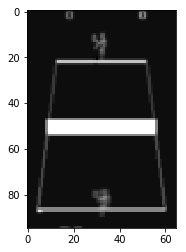

In [12]:
stacked = states[2] + states[3] + states[4]
show(stacked, gray=True)

I've added consecutive frames to give a feel of what the stacked frames would look like. In the actual implementation, they are not added and are fed as a sequence to the network. 

To put all this together, I've defined a wrapper around OpenAI's gym. It performs reduction, frame stacking and action repeat:

In [13]:
class FrameStack:
    """
    Fixed capacity stack-like data structure for state frames. Older frames (smaller indices) are removed
    to make way for new frames (larger indices)
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.frames = []
        
    def clear(self):
        self.frames = []
        
    def push(self, frame):
        if len(self.frames) == 0:
            # If first, copy over all slots
            for i in range(self.capacity):
                self.frames.append(frame)
        else:
            # Remove older frame and add new frame
            self.frames.pop(0)
            self.frames.append(frame)
            
    def get(self):
        if len(self.frames) != self.capacity:
            raise BufferError("Not enough frames in stack")
        return np.array(self.frames)

In [14]:
class GymWrapper:
    def __init__(self, env, action_repeat=1, stack_length=4):
        """
        Creates a new wrapper around the OpenAI environment
        :param env: The OpenAI environment to wrap around
        :param action_repeat: The number of frames to apply each selected action for
        :param stack_length: The number of frames to stack as a single observation for the network input
        """
        self.env = env
        self.action_repeat = action_repeat
        self.stack_length = stack_length
        self.action_count = self.env.action_space.n
        
        self.shape = (95, 65)
        self.frame_stack = FrameStack(stack_length)

    def reset(self):
        """
        Resets the environment
        :return: preprocessed first state of next game
        """
        self.frame_stack.clear()
        state = self.preprocess(self.env.reset())
        self.frame_stack.push(state)
        return self.frame_stack.get()
    
    def preprocess(self, state):
        # Grayscale
        state = state.mean(axis=2)
        # Crop
        state = state[30:220, 15:145]
        # Resize
        state = sc.misc.imresize(state, self.shape)
        # Normalize (1. / 255)
        state = state * 0.0039215686274
        # Required by CNTK
        state = state.astype(np.float32)
        
        return state

    def step(self, action):
        """
        Executes action on the next 'action_repeat' frames
        :param action: The action to execute
        :return: (s, r, done, info): next state, reward, terminated, debugging information
        """
        rewards = 0
        for _ in range(self.action_repeat):
            s, r, done, info = self.env.step(action)
            self.frame_stack.push(self.preprocess(s))
            rewards += r
            if done:
                break
        return self.frame_stack.get(), rewards / 100.0, done, info

    def random_action(self):
        """        
        Returns a random action to execute
        """
        return self.env.action_space.sample()

    def render(self):
        """
        Renders the current state
        """
        self.env.render()

    def close(self):
        """
        Closes the rendering window
        """
        self.env.close()